In [1]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """다수결 투표 앙상블 분류기
    
    매개변수
    ----------------------------
    classifiers: 배열 타입, 크기 =[n_classifiers]
        앙상블에 사용할 분류기
    
    vote: str, {'classlabel','probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로 클래스 레이블을 예측합니다 (보정된 분류기에 추천)
    
    weights: 배열 타입, 크기 =[n_classifiers]
        선택사항, 기본값: None
        'int' 또는 'float'값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------------------------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        ----------------------------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [3]:
from  sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [5]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


[비교] 사이킷런 Voting Classifier

In [6]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]" % (scores['test_score'].mean(), scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.98 (+/- 0.05) [VotingClassifier]


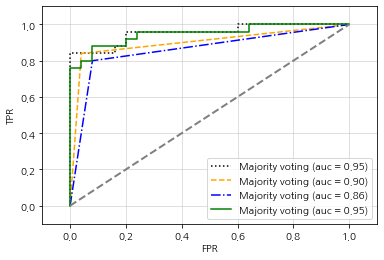

In [11]:
# 테스트 데이터셋에 대한 ROC 곡선 그려보기

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf, lable, clr,ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()

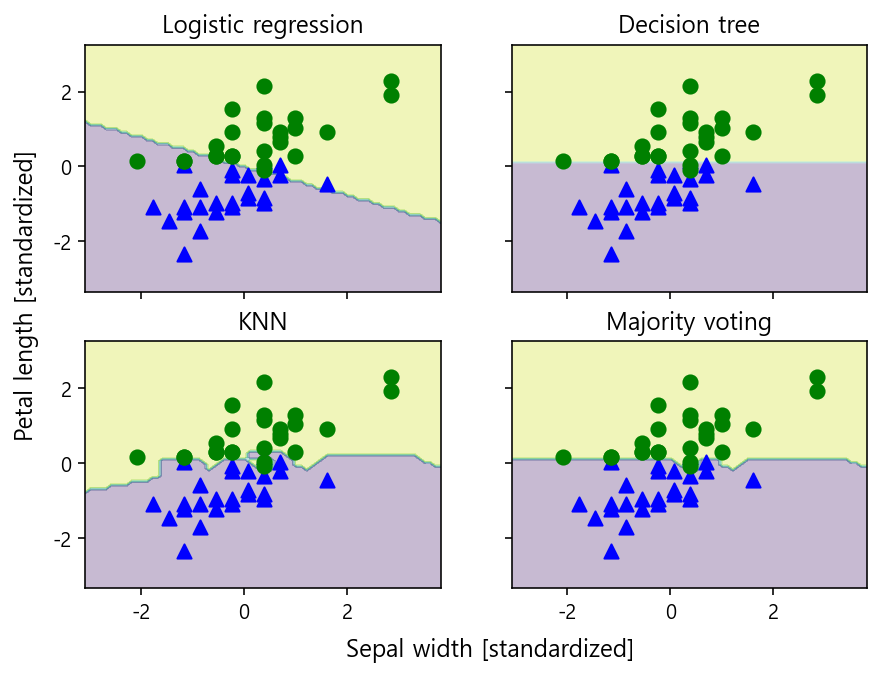

In [14]:
import numpy as np
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], 
                                  c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], 
                                  c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)

plt.show()

In [13]:
# plt.rc('font', family='Malgun Gothic') # 폰트 지정
# plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
# %config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

In [15]:
# 그리드 서치

from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
정확도: 0.98


In [16]:
# 스태킹

from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)


print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 1, 'lr__clf__C': 0.1}
정확도: 0.98


In [17]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

df_wine.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [18]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [19]:
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

tree = DecisionTreeClassifier(criterion='entropy',random_state=1, max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_features=1.0, max_samples=1.0,
                       bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

In [21]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


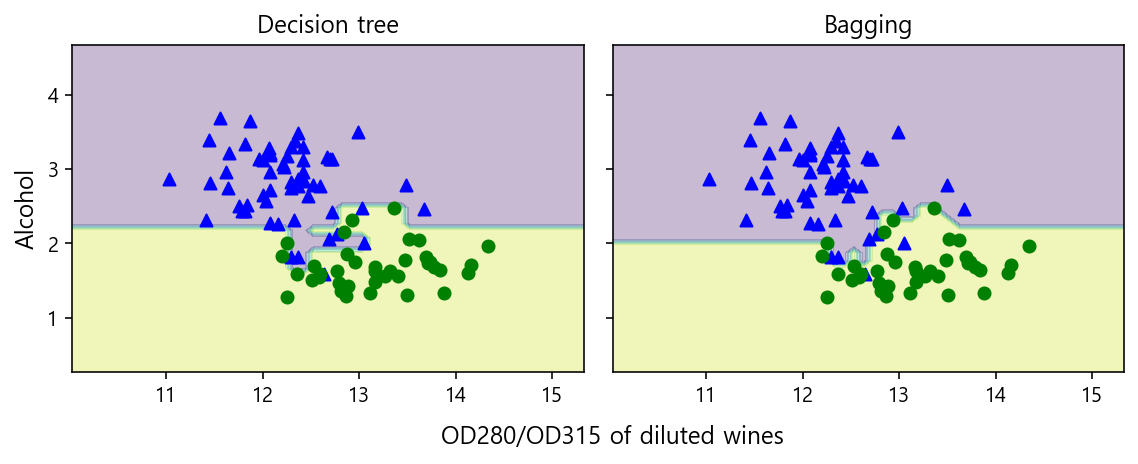

In [22]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

In [23]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=1, max_depth=1)

abc = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=1)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'%(tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875


In [24]:
abc = abc.fit(X_train, y_train)
y_train_pred = abc.predict(X_train)
y_test_pred = abc.predict(X_test)
abc_train = accuracy_score(y_train, y_train_pred)
abc_test = accuracy_score(y_test, y_test_pred)

print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'%(abc_train, abc_test))

에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


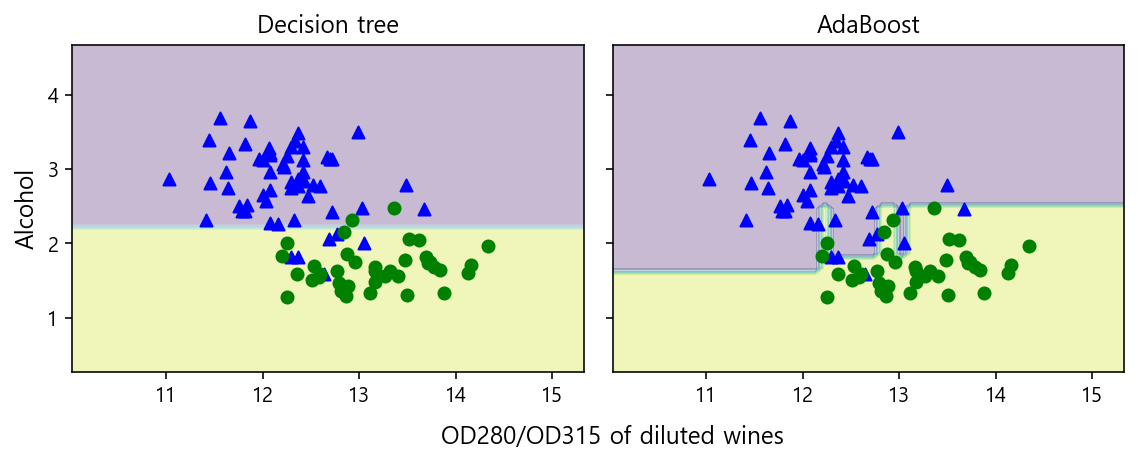

In [26]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, abc],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

In [27]:
# 그래디언트 부스팅
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)
gbrt_train = gbrt.score(X_train, y_train)
gbrt_test = gbrt.score(X_test, y_test)

print('그래디언트 부스팅의 훈련 정확도/테스트 정확도 %.3f/%.3f'%(gbrt_train, gbrt_test))

그래디언트 부스팅의 훈련 정확도/테스트 정확도 1.000/0.917
